# División de Ciencias e Ingenierías de la Universidad de Guanajuato
## Fundamentos de procesamiento digital de imágenes
## TAREA : Funciones de filtrado en frecuencia
### Profesor : Dr. Arturo González Vega
### Alumno : Gustavo Magaña López

In [9]:
from typing import Tuple, List

import numpy as np
import scipy.fftpack as F
import scipy.io as io

import cv2
import matplotlib.image as img

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

import skimage
import skimage.morphology
import skimage.filters

In [52]:
def img_fft(image: np.ndarray, shift: bool = True) -> np.ndarray:
    """
        Ejecutar una Transformada de Fourier visualizable con matplotlib.pyplot.imshow() .
        
        Basado en un snippet encontrado en :
        https://medium.com/@y1017c121y/python-computer-vision-tutorials-image-fourier-transform-part-2-ec9803e63993
        
        Parámetros :
                image : Imagen, representada como un arreglo de numpy (numpy.ndarray)
                shift : Booleano que indica si debe ejecutarse la traslación de la imagen e
                        en el espacio de frecuencia.
    """
    _X = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    if shift:
        _X_shift = np.fft.fftshift(_X)
    _X_complex = _X_shift[:,:,0] + 1j*_X_shift[:,:,1]
    _X_abs = np.abs(_X_complex) + 1 # Evitar que el logaritmo reciba 0 como argumento.
    _X_bounded = 20 * np.log(_X_abs)
    _X_img = 255 * _X_bounded / np.max(_X_bounded)
    _X_img = _X_img.astype(np.uint8)
    
    return _X_img
##

def fft_viz(image: np.ndarray, shift: bool = True) -> None:
    """
        Ver la transformada de fourier de una imagen.
    """
    plt.figure()
    plt.imshow(img_fft(image, shift=shift), cmap='gray')
    plt.show()
##

def pre_fft_processing(
    image: np.ndarray,
      top: int = None,
   bottom: int = None, 
     left: int = None,
    right: int = None,
    borderType: int = None,
) -> np.ndarray:
    """
        Esta función lleva a cabo el proceso de 'padding', necesario antes 
        de aplicar un filtrado en el espacio frecuencial (de Fourier).
        
        Básicamente un wrapper para :
            cv2.copyMakeBorder( image, top, bottom, left, right, borderType)
            
        Donde el tipo de frontera (borderType) puede ser alguno de los siguientes :
            cv2.BORDER_CONSTANT
            cv2.BORDER_REFLECT
            cv2.BORDER_REFLECT_101
            cv2.BORDER_DEFAULT
            cv2.BORDER_REPLICATE
            cv2.BORDER_WRAP
        
        Si faltan uno o más de los parámetros necesarios para llamar cv2.copyMakeBorder(), 
        se implementará un 'padding' por defecto en función de los valores calculados por
        cv2.getOptimalDFTSize().
        
    ##  Parámetros :
                image : Una imagen en blanco y negro, es decir un arreglo bidimensional de numpy.
                  top : Número entero representando el número de pixeles que se agegarán en el margen superior.
               bottom : idem. para el margen inferior. 
                 left : idem. para el margen izquierdo.
                right : idem. para el margen derecho.
           borderType : Alguno de los mencionados anteriormente en el Docstring.


                
    ##  Regresa :
                nimg  : imagen con 'padding'
    """
    override = all(map(lambda x: x if x != 0 else True, [top, bottom, left, right, borderType]))
    if override:
        nimg = cv2.copyMakeBorder(image, top, bottom, left, right, bordertype)
    else:
        row, cols = image.shape
        nrows, ncols = list(map(cv2.getOptimalDFTSize, image.shape))
        right = ncols - cols
        bottom = nrows - rows
        bordertype = cv2.BORDER_CONSTANT #just to avoid line breakup in PDF file
        nimg = cv2.copyMakeBorder(image,0,bottom,0,right,bordertype, value = 0)
    
    return nimg
##

def fft2(
    image: np.ndarray,       
      top: int = None,
   bottom: int = None, 
     left: int = None,
    right: int = None,
    borderType: int = None,
) -> np.ndarray:
    """
    
    Execute:
        x = pre_fft_processing(image, top=top, bottom=bottom, left=left, right=right, borderType=borderType)
        return cv2.dft(np.float32(x),flags=cv2.DFT_COMPLEX_OUTPUT)
        
    Call the cv2's dft, which is supposed to be considerably faster than numpy's implementation.

    See help(pre_fft_processing) for futher details on the preprocessing stage.
    
    """
    nimg = pre_fft_processing(image, top=top, bottom=bottom, left=left, right=right, borderType=borderType)
    dft2 = cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
    
    return dft2
##

def ImPotencia(image: np.ndarray) -> float:
    """
        Calcula la potencia de acuerdo al teorema de Parseval.
    """
    _F = np.fft.fft2(image)
    return np.sum(np.abs(_F)**2) / np.prod(_F.shape)
##

def fourier_meshgrid(image: np.ndarray) -> Tuple[np.ndarray]:
    """
        Genera los arreglos bidimensionales U y V necesarios para poder hacer tanto
        filtrado en frecuencias como la visualización de imágenes en forma de superficies.
        Esto se hace mapeando las intensidades a los valores que tomará la función en el eje
        Z, dados los valores de X y Y que son las coordenadas de los pixeles.
        
    
    Parámetros :
        imagen : Arreglo bidimensional de numpy (numpy.ndarray), es decir una imagen.
        
    Regresa :
        (U, V) : Tuple contieniendo dos arreglos bidimensionales de numpy (numpy.ndarray)
    """
    M, N = image.shape
    u, v = list(map(lambda x: np.arange(0, x), image.shape))
    idx, idy = list(map(lambda x, y: np.nonzero(x > y/2), [u, v], image.shape))
    u[idx] -= M
    v[idy] -= N
    V, U = np.meshgrid(v, u)
    
    return U, V
##

def fourier_distance(U: np.ndarray, V: np.ndarray, centered: bool = True, squared: bool = True) -> np.ndarray:
    """
        Calcula la distancia euclidiana de los puntos de una malla (meshgrid), respecto al centro.
        Por defecto desplaza el centro (distancia 0) al centro de la matriz.
        Asimismo devuelve la distancia al cuadrado puesto que en ocaciones dicho cálculo se hace después
        y calcular la raíz y después elevar al cuadrado sería sólo perder tiempo de cómputo.
        
    Parámetros :
    
                U : Arreglo bidimensional de numpy (numpy.ndarray). 
                V : Idem.
         centered : Booleano indicando si se desea la distancia centrada, 
                    es decir ejecutar np.fft.fftshift(Distancia) una vez calculada
                    la matriz de distancias. 
                        True por defecto.
                        
          squared : Booleano indicando si se desea la distancia al cuadrado 
                    o la distancia euclidiana clásica.
                        True por defecto.
    
    Regresa :
               _d : Matriz con las distancias euclidianas, 
                    de cada coordenada respecto al centro.
    """
    _d = U**2 + V**2
    if not squared:
        _d = np.sqrt(_d)
    if centered:
        _d = np.fft.fftshift(_d)
    
    return _d
##
    
def kernel_gaussiano(image: np.ndarray, sigma: float, kind: str = 'low') -> np.ndarray:
    """
        Calcula un kernel gaussiano para una imagen dada.
    """
    U, V = fourier_meshgrid(image)
    D = fourier_distance(U, V)
    H = np.exp( (-1.0 * D) / (2.0 * sigma**2) )
    
    if kind == 'high' or kind == 'highpass':
        H = 1.0 - H
        
    return H
##
    
def FiltraGaussiana(image: np.ndarray, sigma: float, kind: str = 'low') -> np.ndarray:
    """
    
    """
    kind   = kind.lower()
    _kinds = ['low', 'high', 'lowpass', 'highpass']
    if kind not in _kinds:
        raise Exception(f'Error : Tipo desconocido de filtro \"{kind}\".\n Tipos disponibles : {_kinds}')
    
    H  = kernel_gaussiano(image=image, sigma=sigma, kind=kind)
    _F = np.fft.ifftshift(
            np.fft.fft2(image)
    )
    G  = H * _F
    g  = np.real( np.fft.ifft2( np.fft.ifftshift(G) ))
    
    # Recortamos la imagen a su tamaño original, de ser requerido.
    g = g[:image.shape[0], :image.shape[1]]  
        
    return g  
##

def filtro_disco(image: np.ndarray, radius: int = 5) -> np.ndarray:
    """
    
    """
    _circle = skimage.morphology.disk(radius)
    _filtered = skimage.filters.rank.mean(image, selem=_circle)
    return _filtered
##


In [44]:
#help(cv2.copyMakeBorder)

In [51]:
x = fourier_meshgrid(I)
type(x)

tuple

In [ ]:
"""
cv2.BORDER_CONSTANT
            cv2.BORDER_REFLECT
            cv2.BORDER_REFLECT_101
            cv2.BORDER_DEFAULT
            cv2.BORDER_REPLICATE
            cv2.BORDER_WRAP
"""

In [5]:
I = img.imread('imagenes/mama.tif')

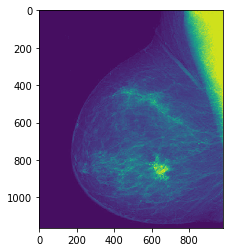

In [28]:
plt.imshow(cv2.copyMakeBorder(I, 0, 0, 0, 0, borderType=cv2.BORDER_CONSTANT))

In [26]:
if filter(lambda x: False if x is None else True, [True, None, cv2.BORDER_CONSTANT]):
    print('Test passed')

Test passed


In [19]:
cv2.BORDER_CONSTANT

0

In [27]:
help(filter)

Help on class filter in module builtins:

class filter(object)
 |  filter(function or None, iterable) --> filter object
 |  
 |  Return an iterator yielding those items of iterable for which function(item)
 |  is true. If function is None, return the items that are true.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [33]:
all( [4, 5, 0])

False

In [34]:
[4, 5, 0].replace(0, 5)

AttributeError: 'list' object has no attribute 'replace'

In [42]:
all(map(lambda x: x if x != 0 else True, [1, 2, 0]))

True

In [41]:
cv2.BORDER_REFLECT101


4